<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span><ul class="toc-item"><li><span><a href="#Импорты-необходимых-библиотек" data-toc-modified-id="Импорты-необходимых-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорты необходимых библиотек</a></span></li><li><span><a href="#Функция-добавления-признаков" data-toc-modified-id="Функция-добавления-признаков-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Функция добавления признаков</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Обзор данных</a></span></li></ul></li><li><span><a href="#Анализ-и-подготовка-данных" data-toc-modified-id="Анализ-и-подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Подготовка признаков</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Проверка-модели-и-выводы" data-toc-modified-id="Проверка-модели-и-выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка модели и выводы</a></span></li></ul></div>

# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

**Цель исследования:** обучить модели с различными гиперпараметрами, чтобы спрогнозировать количество заказов такси на следующий час. Значение метрики RMSE должно быть не более 48.     

**Задачи исследования:**
* загрузить данные, провести ресемплирование по 1 часу.
* проанализировать данные.
* обучить модели с различными гиперпараметрами.
* проверить предсказания на тестовой выборке размером 10% от исходных данных, получить RMSE не более 48.

## Импорты необходимых библиотек

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import catboost as cb
from catboost import CatBoostRegressor


## Функция добавления признаков

In [2]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

## Обзор данных

In [3]:
try:
    data = pd.read_csv('C:\\Users\\Мамуля\\Documents\\taxi.csv')
except:
    data = pd.read_csv('/datasets/taxi.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


**Описание данных:**
* В столбце `datetime` - дата и время,
* В столбце `num_orders` - количество заказов такси в соответствующий момент.

# Анализ и подготовка данных

## Анализ данных

Проведём преобразования: заменим формат данных в первом столбце с `object` на `datetime` и "назначим" этот столбец индексом таблицы. Проверим, представлены ли данные в таблице в хронологическом порядке.

In [4]:
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')

print(data.index.is_monotonic)
data.info()

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Заметно, что в таблице представлены данные о количестве заказов за каждые 10 минут. Теперь посмотрим, какой временной период охватывают данные таблицы, а также посмотрим на их наглядное отображение.

In [6]:
data.index.max()

Timestamp('2018-08-31 23:50:00')

Значит, в таблице данные с 1 марта 2018 года по 31 августа 2018 года включительно - то есть, за 6 месяцев.

<AxesSubplot:xlabel='datetime'>

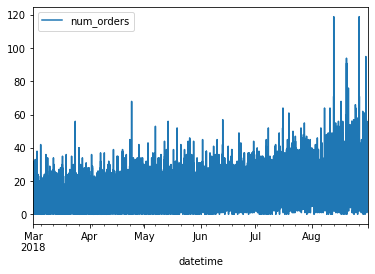

In [7]:
data.plot()

Пока можем сделать вывод только о том, что в среднем количество заказов такси к августу стало больше, чем в марте. Проведём ресемплирование данных: изменим интервал с 10 минут на 1 час - как того требует цель исследования. Поскольку наша задача - спрогнозировать общее количество заказов в час, то агрегированным значением должна быть сумма за все 10-минутные интервалы.

<AxesSubplot:xlabel='datetime'>

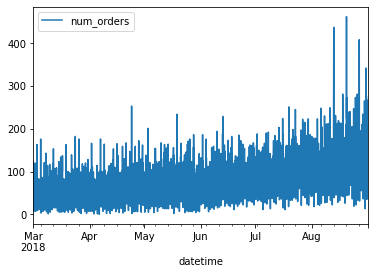

In [8]:
data = data.resample('1H').sum()
data.plot()

Чаще всего сервис такси получал на протяжении полугода от 0 до 100 заказов каждый час, но в июле и, особенно, в августе в значительное количество часовых интервалов заказов было более 100, а в некоторые пиковые часы - и около 400.

<AxesSubplot:xlabel='datetime'>

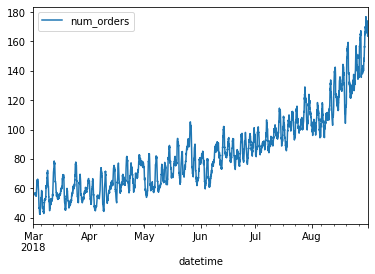

In [9]:
data.rolling(24).mean().plot()

Если сгладить часовые колебания, то хорошо заметно, что действительно наблюдается постепенный рост среднего количества заказов такси в час. Посмотрим, выявит ли программа аналогичный тренд.

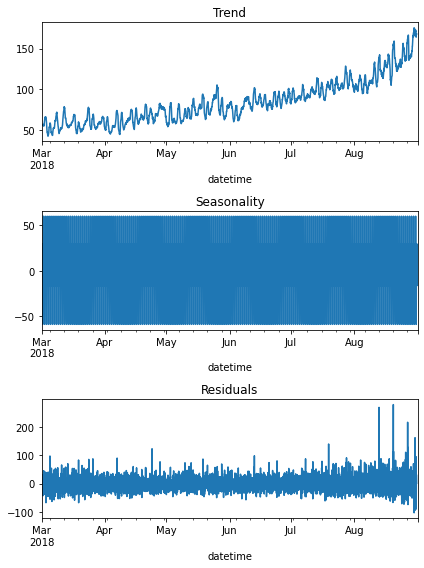

In [10]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Интересно также посмотреть, выявится ли сезонность на более мелких промежутках времени - например, на данных за месяц, неделю и день.

<AxesSubplot:xlabel='datetime'>

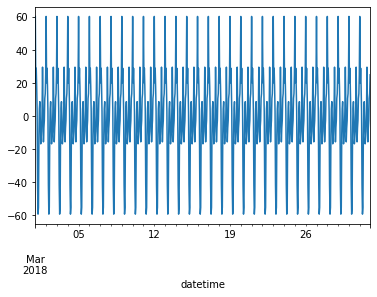

In [11]:
# возьмём данные за месяц
decomposed.seasonal['2018-03-01':'2018-03-31'].plot()

<AxesSubplot:xlabel='datetime'>

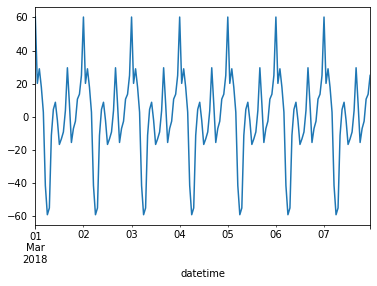

In [12]:
# за неделю
decomposed.seasonal['2018-03-01':'2018-03-07'].plot()

<AxesSubplot:xlabel='datetime'>

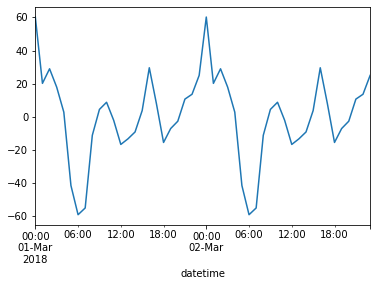

In [13]:
# за двое суток
decomposed.seasonal['2018-03-01':'2018-03-02'].plot()

<AxesSubplot:xlabel='datetime'>

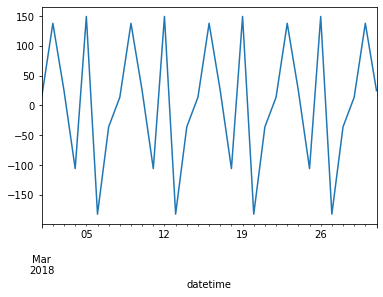

In [14]:
data_day = data.resample('1D').sum()
decomposed_day = seasonal_decompose(data_day)
decomposed_day.seasonal['2018-03-01':'2018-03-31'].plot()

Видим, что сезонная составляющая на сутках проявляется чётко: пик заказов приходится на время около полуночи, минимальное количество - на утренние часы. Локальные пики фиксируются также около 9-10 часов утра и около 14 часов.

В исследовании мы имеем дело с нестационарным временным рядом, поскольку виден и рост среднего и рост дисперсии со временем. Интересно посмотреть, как будут выглядеть данные, если сделать временной ряд более стационарным.

<AxesSubplot:xlabel='datetime'>

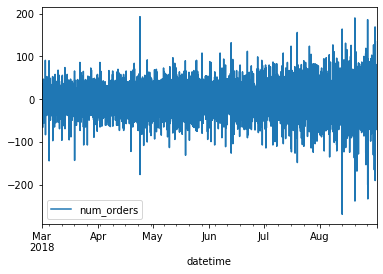

In [15]:
data_st = data - data.shift()
data_st.plot()

## Подготовка признаков

Создадим новые признаки, которые могут быть полезны для работы модели. Как представляется, целесообразно создать следующие новые столбцы: месяц, день, день недели, "отстающие значения", а также скользящее среднее. Для этого была создана соответствующая функция (прописана в п.1.2). 

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Попробуем сгладить данные, взяв в отстающие значение за предыдущие сутки, а скользящее среднее - за двое суток.

In [17]:
make_features(data, 24, 48)
data.tail()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-31 19:00:00,136,19,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,170.895833
2018-08-31 20:00:00,154,20,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,170.208333
2018-08-31 21:00:00,159,21,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,169.437500
2018-08-31 22:00:00,223,22,4,159.0,154.0,136.0,207.0,217.0,197.0,116.0,...,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,169.208333
2018-08-31 23:00:00,205,23,4,223.0,159.0,154.0,136.0,207.0,217.0,197.0,...,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,170.166667


Отделим целевой признак и разделим данные на тестовую и валидационную выборки.

In [18]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

# избавимся от строк, в которых есть значения NaN
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

# check
print(train.index.min(), train.index.max())
test.index.min(), test.index.max()

2018-03-03 00:00:00 2018-08-13 13:00:00


(Timestamp('2018-08-13 14:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

Зададим уровень для проверки будущих прогнозов. Для этого попробуем предсказать количество заказов без обучения.  

In [19]:
# предсказания по медианному значению
pred_median = np.ones(test.shape) * train['num_orders'].median()

# предсказания на основе предыдущего значения ряда
pred_previous = test.shift(fill_value=train['num_orders'].iloc[-1])

rmse_med = mean_squared_error(test, pred_median, squared=False)
rmse_prev = mean_squared_error(test, pred_previous, squared=False)

print('Среднее количество заказов в час:', data['num_orders'].mean())
print('RMSE при предсказании медианой:', rmse_med)
print('RMSE при предсказании предыдущим значением:', rmse_prev)

Среднее количество заказов в час: 84.42278079710145
RMSE при предсказании медианой: 84.81249956415401
RMSE при предсказании предыдущим значением: 53.62601244615046


Видим, что предсказание предыдущим значением - довольно эффективный способ. При тестировании моделей поставим задачу улучшить метрику относительно этого уровня.

# Обучение моделей

## Линейная регрессия

Посмотрим, какие значения RMSE даст линейная регрессия.

In [20]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

# для временных рядов нужен особый порядок кросс-валидации - без перемешивания 
# воспользуемся инструментом TimeSeriesSplit
ts_cv = TimeSeriesSplit(n_splits=4, gap=24, test_size=700)

lr_cv = cross_validate(model_lr, features_train, target_train, cv=ts_cv, 
                     scoring='neg_root_mean_squared_error',
                    return_train_score=True)
lr_cv = pd.DataFrame(lr_cv)
display(lr_cv)
lr_cv.describe()

,fit_time,score_time,test_score,train_score
0,0.008002,0.002000,-25.472830,-20.844806
1,0.003000,0.002001,-26.107444,-22.153044
2,0.003999,0.001001,-27.093226,-23.132585
3,0.004000,0.002000,-33.569092,-23.941918


,fit_time,score_time,test_score,train_score
count,4.000000,4.000000,4.000000,4.000000
mean,0.004750,0.001750,-28.060648,-22.518088
std,0.002218,0.000500,3.732321,1.333920
min,0.003000,0.001001,-33.569092,-23.941918
25%,0.003750,0.001750,-28.712192,-23.334918
50%,0.004000,0.002000,-26.600335,-22.642815
75%,0.005001,0.002000,-25.948790,-21.825984
max,0.008002,0.002001,-25.472830,-20.844806


Модель линейной регрессии относительно неплохо справилась с предсказанием количества заказов, в среднем метрика RMSE достигла 22,5. Попробуем другие модели.

## XGBoost

Попробуем добиться улучшения качества предсказаний с помощью модели градиентного бустинга, у которой можно подобрать различные параметры.

In [21]:
model_xgb = xgb.XGBRegressor(booster='gblinear', 
                             objective='reg:squarederror', 
                             random_state=12345)

In [22]:
params = {'n_estimators': range (200, 700, 100),
              'max_depth': [3, 4, 5],
         'learning_rate': [0.2, 0.1, 0.05]}
grid = GridSearchCV(model_xgb, params, cv=ts_cv, scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)


[15:40:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:40:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:40:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters:

GridSearchCV(cv=TimeSeriesSplit(gap=24, max_train_size=None, n_splits=4, test_size=700),
             estimator=XGBRegressor(base_score=None, booster='gblinear',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max...
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=12345, reg_alpha=None,
                                    re

In [23]:
xgb_scores = pd.DataFrame(grid.cv_results_)

display(xgb_scores.head())
display(xgb_scores[xgb_scores['rank_test_score'] == 1])

# также запомним лучший средний счёт
xgb_score = xgb_scores[xgb_scores['rank_test_score'] == 1]['mean_test_score'].values[0]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.068266,0.009886,0.004251,4.336352e-04,0.2,3,200,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",-24.837855,-25.985223,-27.115085,-33.689101,-27.906816,3.434119,41
1,0.081768,0.013903,0.004251,4.334632e-04,0.2,3,300,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",-24.859453,-25.946698,-27.098072,-33.638945,-27.885792,3.414604,33
2,0.108274,0.015694,0.005002,5.430242e-07,0.2,3,400,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",-24.907922,-25.984958,-27.094841,-33.622103,-27.902456,3.391557,38
3,0.140032,0.029102,0.005001,1.225094e-03,0.2,3,500,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",-24.945307,-25.970289,-27.106196,-33.623900,-27.911423,3.385507,44
4,0.152534,0.025515,0.005001,5.462856e-07,0.2,3,600,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",-24.965511,-25.977389,-27.094885,-33.611509,-27.912323,3.375522,45


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
41,0.079768,0.015852,0.004251,0.000433,0.05,5,300,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",-24.669941,-25.816779,-26.857415,-33.54419,-27.722081,3.449288,1


Лучшая модель XGBoost (300 деревьев, скорость обучения 0.05, глубина 4) даёт качество предсказаний около 27,7 по RMSE.

## CatBoost

Обучим также модель градиентного бустинга CatBoost.

In [24]:
model_cb = CatBoostRegressor(loss_function='RMSE', random_state=12345,
                            verbose=100)

params = {'l2_leaf_reg': [0.3, 0.4, 0.5],
              'depth': [3, 5, 7],
              'learning_rate': [0.09, 0.1, 0.15],
         'iterations': [80, 100, 120]}
grid_cb = GridSearchCV(model_cb, params, cv=ts_cv, scoring='neg_root_mean_squared_error')
grid_cb.fit(features_train, target_train)

0:	learn: 28.4104317	total: 153ms	remaining: 12.1s
79:	learn: 16.6722278	total: 219ms	remaining: 0us
0:	learn: 30.3441855	total: 1.63ms	remaining: 129ms
79:	learn: 18.4249779	total: 76.6ms	remaining: 0us
0:	learn: 32.1993468	total: 1.31ms	remaining: 104ms
79:	learn: 19.7607877	total: 82.5ms	remaining: 0us
0:	learn: 33.3532015	total: 1.26ms	remaining: 99.4ms
79:	learn: 20.8502369	total: 95.4ms	remaining: 0us
0:	learn: 28.2972507	total: 997us	remaining: 78.8ms
79:	learn: 16.3317255	total: 61.2ms	remaining: 0us
0:	learn: 30.2374282	total: 1.08ms	remaining: 85.1ms
79:	learn: 18.2168333	total: 70ms	remaining: 0us
0:	learn: 32.0789560	total: 1.16ms	remaining: 91.6ms
79:	learn: 19.6308007	total: 84.5ms	remaining: 0us
0:	learn: 33.2170581	total: 1.57ms	remaining: 124ms
79:	learn: 20.5920453	total: 102ms	remaining: 0us
0:	learn: 27.7435063	total: 940us	remaining: 74.3ms
79:	learn: 14.9679793	total: 64.8ms	remaining: 0us
0:	learn: 29.7158988	total: 973us	remaining: 76.9ms
79:	learn: 17.2705201	t

GridSearchCV(cv=TimeSeriesSplit(gap=24, max_train_size=None, n_splits=4, test_size=700),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001E90FD984C0>,
             param_grid={'depth': [3, 5, 7], 'iterations': [80, 100, 120],
                         'l2_leaf_reg': [0.3, 0.4, 0.5],
                         'learning_rate': [0.09, 0.1, 0.15]},
             scoring='neg_root_mean_squared_error')

In [25]:
cb_scores = pd.DataFrame(grid_cb.cv_results_)

display(cb_scores.head())
display(cb_scores[cb_scores['rank_test_score'] == 1])

# запомним лучший результат для сравнения
cb_score = cb_scores[cb_scores['rank_test_score'] == 1]['mean_test_score'].values[0]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_l2_leaf_reg,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.182536,0.086773,0.005001,0.001732,3,80,0.3,0.09,"{'depth': 3, 'iterations': 80, 'l2_leaf_reg': ...",-24.550132,-24.829954,-25.266155,-34.389532,-27.258944,4.124747,81
1,0.177101,0.093560,0.021507,0.030902,3,80,0.3,0.1,"{'depth': 3, 'iterations': 80, 'l2_leaf_reg': ...",-23.917645,-24.463578,-25.244023,-34.116699,-26.935486,4.172786,76
2,0.124974,0.013036,0.003751,0.000433,3,80,0.3,0.15,"{'depth': 3, 'iterations': 80, 'l2_leaf_reg': ...",-24.340286,-23.887498,-24.443164,-33.209246,-26.470049,3.896489,63
3,0.177933,0.096713,0.003501,0.000500,3,80,0.4,0.09,"{'depth': 3, 'iterations': 80, 'l2_leaf_reg': ...",-24.492965,-24.858456,-25.090271,-34.344998,-27.196673,4.132577,80
4,0.124736,0.013777,0.003501,0.000500,3,80,0.4,0.1,"{'depth': 3, 'iterations': 80, 'l2_leaf_reg': ...",-24.195928,-24.349482,-25.389872,-34.124867,-27.015037,4.130478,77


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_l2_leaf_reg,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
80,0.515332,0.058982,0.004001,2.598106e-07,7,120,0.5,0.15,"{'depth': 7, 'iterations': 120, 'l2_leaf_reg':...",-23.135495,-23.333536,-24.199748,-30.920362,-25.397285,3.213768,1


Модель CatBoost со 120 деревьями, глубиной 7, скоростью обучения 0.15 и коэффициентом l2 равным 0.5, показала лучший результат RMSE 25,4 - хотя он не намного отличается от результатов двух других моделей. Сравним наглядно:

In [26]:
all_scores = pd.DataFrame(data=[['LinearRegression', lr_cv['test_score'].mean()],
                          ['XGBoost', xgb_score],
                         ['CatBoost', cb_score]],
                         columns=['Модель', 'RMSE'])

all_scores

,Модель,RMSE
0,LinearRegression,-28.060648
1,XGBoost,-27.722081
2,CatBoost,-25.397285


Итак, для проверки на тестовой выборке возьмём модель CatBoost с перечисленными лучшими параметрами, сохранённую как **model_cb**.

# Проверка модели и выводы

Посмотрим, как выбранная модель справится с предсказанием на тестовых данных.

In [27]:
model_cb = CatBoostRegressor(loss_function='RMSE', random_state=12345,
                            verbose=100, l2_leaf_reg=0.3, depth=7,
                            learning_rate=0.1, iterations=120)
model_cb.fit(features_train, target_train)
predicted = model_cb.predict(features_test)
qual_lg = mean_squared_error(target_test, predicted, squared=False)
qual_lg

0:	learn: 36.8688430	total: 5.41ms	remaining: 644ms
100:	learn: 16.9040977	total: 510ms	remaining: 95.9ms
119:	learn: 15.8999946	total: 606ms	remaining: 0us


42.294612073957246

Таким образом, было достигнуто значение RMSE 42.3 - то есть, удалось улучшить качество предсказаний по сравнению с предсказаниями без обучения и по сравнению с целевым значением метрики.

Интересно посмотреть, как предсказанные значения будут выглядеть на графике - в сравнении с реальными данными.

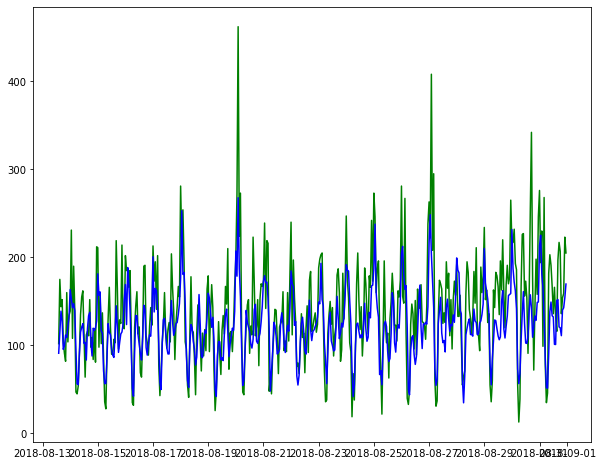

In [28]:
plt.figure(figsize=(10,8))
plt.plot(target_test.index, 
         target_test, 
         'g-', 
         target_test.index, 
         predicted,
         'b-')

В целом видим, что модель справилась достаточно хорошо - ей удались предсказания часов со средним количеством заказов, а также многие "провалы" в заказах, которые зависят от дней недели. В то же время, с предсказанием пиковых количеств заказов она справляется не так хорошо.

**Выводы**

Добиться высокого качества предсказаний удалось за счёт введения большого количества столбцов с отставанием целевого значения, а также за счёт большого окна скользящего среднего.

На обучающей выборке все модели показали хорошее качество предсказаний, что может быть обусловлено ещё и более стационарным характером данных на временном промежутке, охватывающем обучающую выборку.

На временном периоде, в который попала тестовая выборка, оказалось сразу несколько пиковых значений (что увеличивает дисперсию) и в целом реализовался тренд на рост среднего количества заказов. Поэтому качество предсказаний даже у лучшей модели (CatBoostRegressor) заметно ухудшилось.